In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,roc_curve,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [8]:
# Dataset
df = pd.read_csv('data.csv')
df.head()

,filename,tempo,beats,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00081.au,103.359375,50,0.380260,0.248262,2116.942959,1956.611056,4196.107960,0.127272,-26.929785,...,14.336612,-13.821769,7.562789,-6.181372,0.330165,-6.829571,0.965922,-7.570825,2.918987,blues
1,blues.00022.au,95.703125,44,0.306451,0.113475,1156.070496,1497.668176,2170.053545,0.058613,-233.860772,...,-2.250578,3.959198,5.322555,0.812028,-1.107202,-4.556555,-2.436490,3.316913,-0.608485,blues
2,blues.00031.au,151.999081,75,0.253487,0.151571,1331.073970,1973.643437,2900.174130,0.042967,-221.802549,...,-13.037723,-12.652228,-1.821905,-7.260097,-6.660252,-14.682694,-11.719264,-11.025216,-13.387260,blues
3,blues.00012.au,184.570312,91,0.269320,0.119072,1361.045467,1567.804596,2739.625101,0.069124,-207.208080,...,-0.613248,0.384877,2.605128,-5.188924,-9.527455,-9.244394,-2.848274,-1.418707,-5.932607,blues
4,blues.00056.au,161.499023,74,0.391059,0.137728,1811.076084,2052.332563,3927.809582,0.075480,-145.434568,...,7.457218,-10.470444,-2.360483,-6.783623,2.671134,-4.760879,-0.949005,0.024832,-2.005315,blues


In [9]:
# check information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   filename            1000 non-null   object 
 1   tempo               1000 non-null   float64
 2   beats               1000 non-null   int64  
 3   chroma_stft         1000 non-null   float64
 4   rmse                1000 non-null   float64
 5   spectral_centroid   1000 non-null   float64
 6   spectral_bandwidth  1000 non-null   float64
 7   rolloff             1000 non-null   float64
 8   zero_crossing_rate  1000 non-null   float64
 9   mfcc1               1000 non-null   float64
 10  mfcc2               1000 non-null   float64
 11  mfcc3               1000 non-null   float64
 12  mfcc4               1000 non-null   float64
 13  mfcc5               1000 non-null   float64
 14  mfcc6               1000 non-null   float64
 15  mfcc7               1000 non-null   float64
 16  mfcc8  

In [10]:
# Drop 'filename' column
df.drop('filename',axis=1,inplace=True)

In [12]:
# Value counts for target label
df['label'].value_counts()

blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100
Name: label, dtype: int64

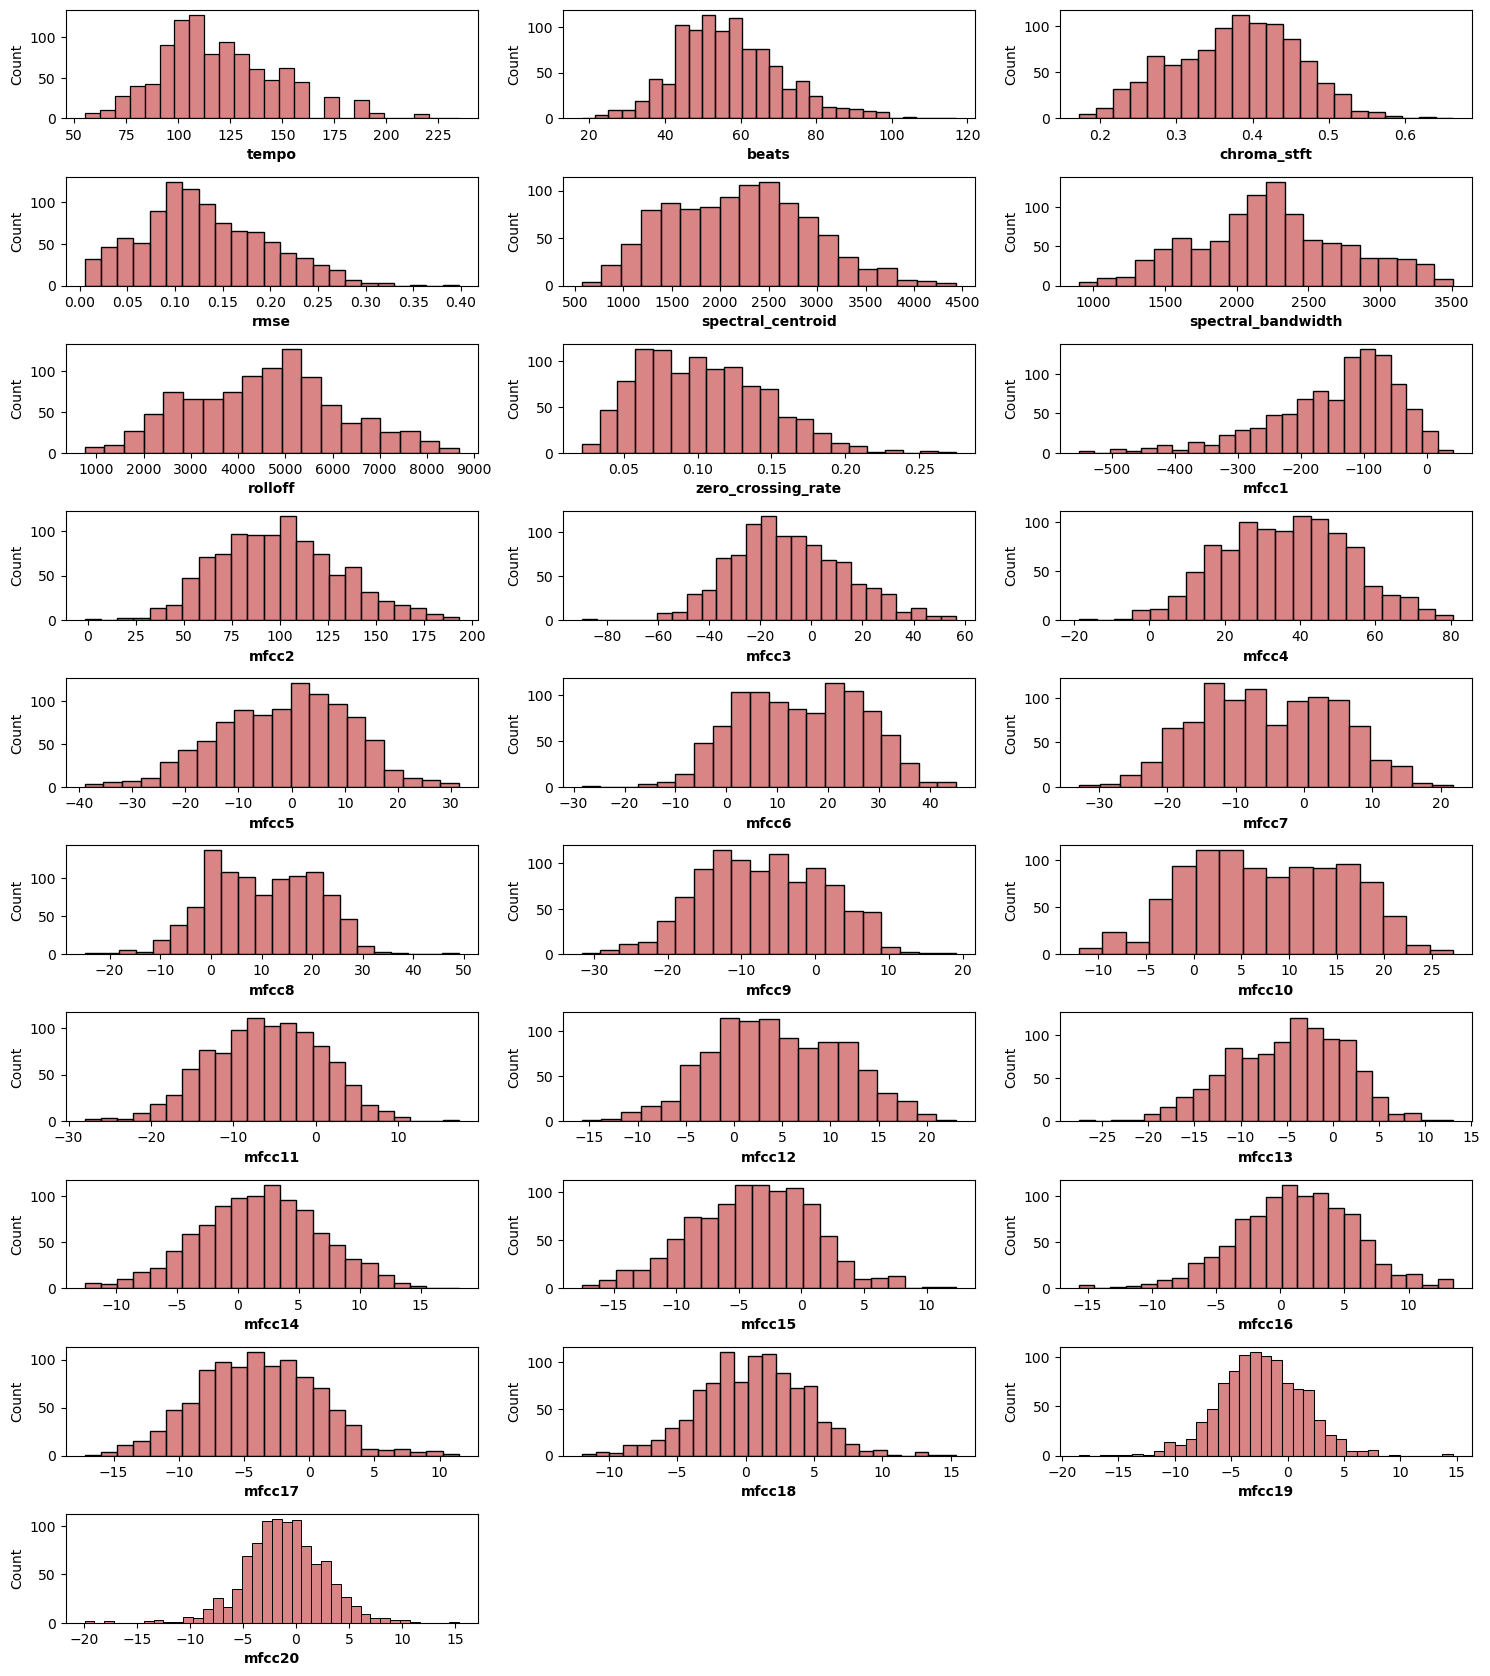

In [16]:
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']

plt.figure(figsize=(15, 100))
for i, col in enumerate(numeric_features):
    plt.subplot(60, 3, i+1)
    sns.histplot(x=df[col], color='indianred')
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

In [17]:
# Independet 
X = df.drop('label',axis=1)
# Dependent
y = df['label']

In [32]:
# Labelencoding
le=LabelEncoder()
y = le.fit_transform(y)

In [39]:
def evaluate_clf(true, predicted):
    '''
    This function takes in true values and predicted values
    Returns: Accuracy, F1-Score, Precision, Recall
    '''
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted,average='weighted') # Calculate F1-score
    precision = precision_score(true, predicted,average='weighted') # Calculate Precision
    recall = recall_score(true, predicted,average='weighted')  # Calculate Recall
    return acc, f1 , precision, recall

In [22]:
# Create cost of the model as per data description
def total_cost(y_true, y_pred):
    '''
    This function takes y_ture, y_predicted, and prints Total cost due to misclassification
   
    '''
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = 10*fp + 500*fn
    return cost

In [23]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    cost_list=[]
    models_list = []
    accuracy_list = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)
        train_cost = total_cost(y_train, y_train_pred)


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)
        test_cost = total_cost(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))
        print(f'- COST: {train_cost}.')

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        print(f'- COST: {test_cost}.')
        cost_list.append(test_cost)
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list, cost_list)), columns=['Model Name', 'Cost']).sort_values(by=["Cost"])
        
    return report

In [24]:
# Dictionary which contains models for experiment
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "AdaBoost Classifier": AdaBoostClassifier(),
    "SVM":SVC()
}

In [40]:
report = evaluate_models(X, y, models)

ValueError: not enough values to unpack (expected 5, got 4)